<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/movie_revenue_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Libraries and config

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime

sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
import gc
gc.collect()

0

In [3]:
!nvidia-smi

Sun Jun  9 09:32:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
movies = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')
credits = pd.read_csv("gdrive/My Drive/TFG/tmdb_5000_credits.csv")

In [0]:
# Merge with credits
data = movies.merge(credits, how='left', left_on=['id','title'], right_on=['movie_id','title'])
data.drop(['movie_id','Unnamed: 0'],axis=1, inplace= True)

In [7]:
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [8]:
data.describe().astype(int)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803,4803,4803,4803,4801,4803,4803
mean,29045039,57165,21,82260638,106,6,690
std,40722391,88694,31,162857100,22,1,1234
min,0,5,0,0,0,0,0
25%,790000,9014,4,0,94,5,54
50%,15000000,14629,12,19170001,103,6,235
75%,40000000,58610,28,92917187,118,6,737
max,380000000,459488,875,2787965087,338,10,13752


In [9]:
data.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"Año 2154. Jake Sully, un ex-marine condenado a...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,Siguiendo la estela de lo sucedido en “Piratas...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,Un críptico mensaje del pasado envía a James B...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,"Hace ocho años que Batman desapareció, dejando...",112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"Adaptación de ‘Una princesa de Marte’, la prim...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
# Get features

data = data[['original_title','budget','genres','original_language','production_companies','production_countries',
             'release_date','runtime','spoken_languages','cast','crew','vote_average','revenue']]

# Quitamos na hay 2 runtime que faltan
data.dropna(inplace=True)

In [11]:
data.describe().astype(int)
# Quitamos duracion menor a 40 min

,budget,runtime,vote_average,revenue
count,4800,4800,4800,4800
mean,29060068,106,6,82312051
std,40730294,22,1,162895004
min,0,0,0,0
25%,800000,94,5,0
50%,15000000,103,6,19181992
75%,40000000,118,6,92938861
max,380000000,338,10,2787965087


In [12]:
print('Without budget: ',len(data[data.budget == 0]))
print('Without runtime: ',len(data[data.runtime == 0]))
print('Without revenue: ',len(data[data.revenue == 0]))

Without budget:  1036
Without runtime:  34
Without revenue:  1424


In [0]:
data = data[data['runtime']>40]

In [14]:
data.describe().astype(int)
# Quitamos pelis con ingresos y presupuesto 0 | O metemos mean de los datos

,budget,runtime,vote_average,revenue
count,4764,4764,4764,4764
mean,29278511,107,6,82933512
std,40805985,20,1,163351865
min,0,41,0,0
25%,1000000,94,5,0
50%,15000000,104,6,19614174
75%,40000000,118,6,93784581
max,380000000,338,10,2787965087


In [0]:
#data = data[data['budget']>0]
data = data[data['revenue']>0] 

In [16]:
data.describe().astype(int)

,budget,runtime,vote_average,revenue
count,3375,3375,3375,3375
mean,38895763,110,6,117065260
std,44206378,21,0,183499699
min,0,41,0,5
25%,8500000,96,5,15369235
50%,25000000,106,6,51801187
75%,52000000,121,6,140168399
max,380000000,338,10,2787965087


In [17]:
len(data[data['budget']==0])
# Inputaremos el budget mas a delante

146

DISTRIBUTION PLOTS 



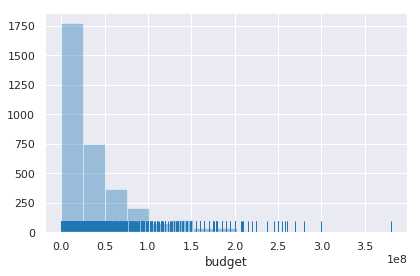

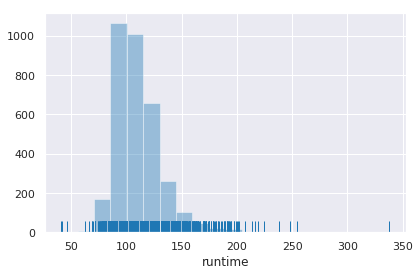

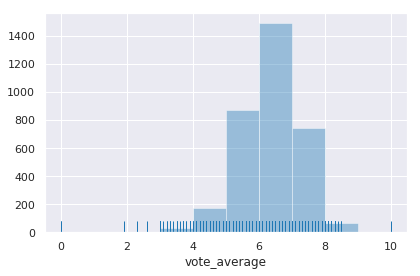

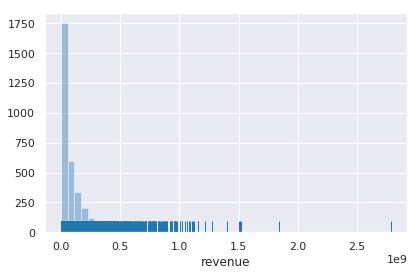

In [18]:
from IPython.display import display

print('DISTRIBUTION PLOTS \n')

sns.distplot(data['budget'], kde=False, rug=True, bins=15)
plt.tight_layout()
plt.show()

sns.distplot(data['runtime'].dropna(), kde=False, rug=True, bins=20)
plt.tight_layout()
plt.show()

sns.distplot(data['vote_average'], kde=False, rug=True, bins=10)
plt.tight_layout()
plt.show()

sns.distplot(data['revenue'], kde=False, rug=True)
plt.tight_layout()
plt.show()

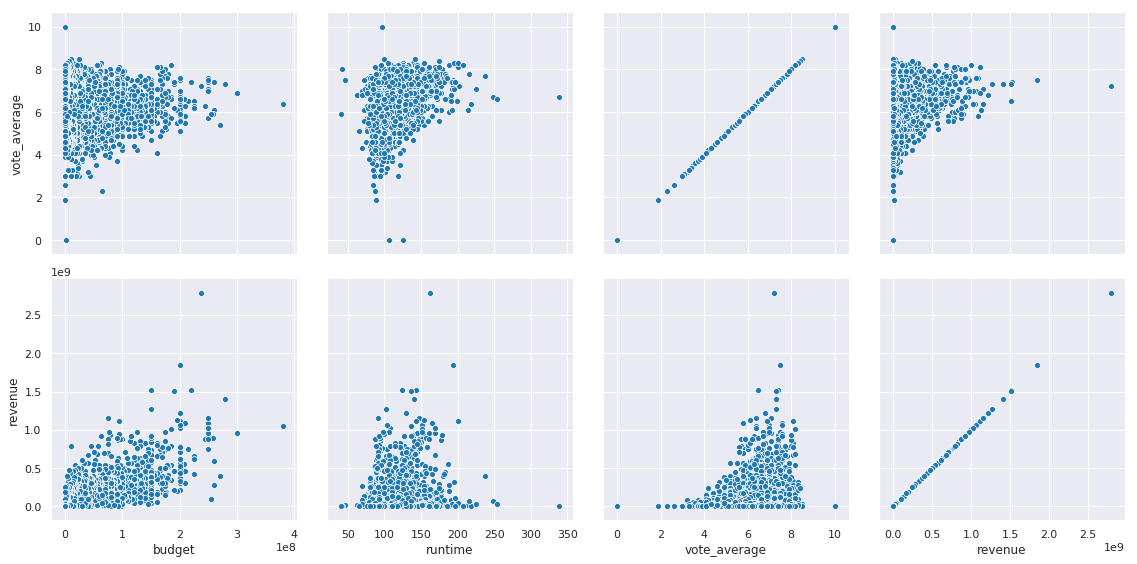

In [19]:
sns.pairplot(data, x_vars=['budget','runtime','vote_average','revenue'], y_vars=['vote_average','revenue'], height=4);

In [0]:
def eval_cell(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []
  
  return cell_array

In [0]:
# Get ids
def get_ids(cell):
  
  cell_array = eval_cell(cell)

  if len(cell_array)>0:
    ids_list = [v['id'] for v in cell_array]
    
  else:
    ids_list = []
  
  return ids_list

def get_cast_ids(cell):
  
  cell_array = eval_cell(cell)
  
  if len(cell_array) >= 5:
    lim = 5
  else:
    lim = len(cell_array)
    
  ids_list = [cell_array[i]['id'] for i in range(0,lim)]
  
  return ids_list

def get_crew_ids(cell,filter_staff):
  
  cell_array = eval_cell(cell)
    
  staff_members_ids = [member['id'] for member in cell_array if member['job'] == filter_staff]
    
  return staff_members_ids

def get_countries(cell):
  
  cell_array = eval_cell(cell)
  
  countries = [list(e.values())[0] for e in cell_array]
  
  return countries

In [0]:
# Ver si cambio ids por nombres
from sklearn.preprocessing import MultiLabelBinarizer

# Crate Dataframe with ids
def create_df_ids(ids,column_name):
  
  enc = MultiLabelBinarizer()
  np_ids = enc.fit_transform(ids)
  
  # Save encoder in a pickle
  
  column_names = []
  print('Num classes of '+ column_name + ': ' + str(len(enc.classes_)))
  
  for c in enc.classes_:
    column_names.append(column_name + '_' + str(c))
  
  df_ids = pd.DataFrame(data = np_ids, index=data.index, columns=column_names)
  
  return df_ids


# Merge dataframe ids with data
def merge_ids(data,column_name):
  
  if column_name == 'crew':
    df = data.copy()
  
    staff = ['Producer','Editor','Director','Original Music Composer','Writer','Screenplay']
    for i in staff:

      ids = data['crew'].apply(lambda x: get_crew_ids(x,i))

      df_ids = create_df_ids(ids,i)

      df = df.join(df_ids)
    return df
  
  elif column_name == 'cast':
    ids = data[column_name].apply(lambda x: get_cast_ids(x))
  
  elif column_name in ['production_countries','spoken_languages']:
    ids = data[column_name].apply(lambda x: get_countries(x))
    
  else:
    ids = data[column_name].apply(lambda x: get_ids(x))
    
  df_ids = create_df_ids(ids,column_name)
  
  df = data.copy()
  df = df.join(df_ids)
  
  return df

In [23]:
columns_with_ids = ['genres','production_companies','cast','crew','production_countries','spoken_languages']

for i in columns_with_ids:
  data = merge_ids(data,i)

Num classes of genres: 19
Num classes of production_companies: 3759
Num classes of cast: 6451
Num classes of Producer: 3713
Num classes of Editor: 1274
Num classes of Director: 1667
Num classes of Original Music Composer: 777
Num classes of Writer: 1205
Num classes of Screenplay: 2339
Num classes of production_countries: 63
Num classes of spoken_languages: 78


In [0]:
# Original_language
dummies_languages = pd.get_dummies(data['original_language'], drop_first=True)
data = data.join(dummies_languages)

In [0]:
# https://stats.stackexchange.com/questions/65900/does-it-make-sense-to-use-a-date-variable-in-a-regression

def separate_date(date):
  
  date = date.split('-')
  year = int(date[0])
  month = int(date[1])
  day = int(date[2])
  
  return year, month, day

def to_date_type(date):
  
  date = separate_date(date)
  date = datetime.datetime(date[0],date[1],date[2])
  
  return date

In [0]:
data['year'], data['month'], data['day'] = zip(*data.release_date.apply(lambda x: separate_date(x)))
data['release_date'] = data['release_date'].apply(lambda x: to_date_type(x))

In [0]:
oscars = pd.read_csv('gdrive/My Drive/TFG/oscars.csv')

In [0]:
def month_to_int(argument):
    switcher = {
        "enero": 1,
        "febrero": 2,
        "marzo": 3,
        "abril": 4,
        "mayo": 5,
        "junio": 6,
        "julio": 7,
        "agosto": 8,
        "septiembre": 9,
        "octubre": 10,
        "noviembre": 11,
        "diciembre": 12
    }
    return switcher.get(argument)
  
def oscars_to_date_type(date):
  
  date = date.split(" ")
  date = datetime.datetime(int(date[4]),month_to_int(date[2]),int(date[0]))
  
  return date

In [0]:
oscars.Fecha = oscars.Fecha.apply(lambda x: oscars_to_date_type(x))
# En los oscars premian las peliculas del año anterior "entre el 1 de enero y el 31 de diciembre del año anterior en Los Angeles"
oscars['year'] = oscars.Fecha.apply(lambda x: x.year-1)
oscars.columns = ['oscars_date','year']

In [0]:
data = data.join(oscars.set_index('year'), on='year')
data['days_for_oscars'] = (data['oscars_date'] - data['release_date']).dt.days

In [0]:
data = data[~pd.isna(data.days_for_oscars)] 

In [0]:
suma = data.sum(axis=0, numeric_only=True).astype(int).sort_values().to_dict()

In [0]:
columns_to_drop = {k for k, v in suma.items() if v < 4}

In [34]:
data.shape

(3372, 21390)

In [0]:
data.drop(columns=columns_to_drop,inplace=True)

In [36]:
data.shape

(3372, 3230)

In [37]:
data.head(1)

,original_title,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,cast,crew,vote_average,revenue,genres_12,genres_14,genres_16,genres_18,genres_27,genres_28,genres_35,genres_36,genres_37,genres_53,genres_80,genres_99,genres_878,genres_9648,genres_10402,genres_10749,genres_10751,genres_10752,genres_10769,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,...,spoken_languages_hu,spoken_languages_is,spoken_languages_it,spoken_languages_ja,spoken_languages_ko,spoken_languages_la,spoken_languages_nl,spoken_languages_no,spoken_languages_pl,spoken_languages_pt,spoken_languages_ro,spoken_languages_ru,spoken_languages_sq,spoken_languages_sr,spoken_languages_sv,spoken_languages_sw,spoken_languages_th,spoken_languages_tr,spoken_languages_uk,spoken_languages_ur,spoken_languages_vi,spoken_languages_yi,spoken_languages_zh,cn,da,de,en,es,fr,hi,it,ja,ko,ru,zh,year,month,day,oscars_date,days_for_oscars
0,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.2,2787965087,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2009,12,10,2010-03-07,87.0


In [0]:
# Input values when  budget = 0

train = data.drop(['original_title','spoken_languages','genres','original_language','production_companies',
           'production_countries','release_date','cast','crew','oscars_date','day'], axis=1)

train = train.reset_index(drop=True)
train.loc[train['budget'] == 0, 'budget'] = np.NaN

In [39]:
# Use KNN to input the values
from fancyimpute import KNN 

train_cols = list(train)

train = pd.DataFrame(KNN(k=5).fit_transform(train))
train.columns = train_cols

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


Imputing row 1/3372 with 0 missing, elapsed time: 257.232
Imputing row 101/3372 with 0 missing, elapsed time: 257.235
Imputing row 201/3372 with 0 missing, elapsed time: 257.237
Imputing row 301/3372 with 0 missing, elapsed time: 257.239
Imputing row 401/3372 with 0 missing, elapsed time: 257.242
Imputing row 501/3372 with 0 missing, elapsed time: 257.245
Imputing row 601/3372 with 0 missing, elapsed time: 257.247
Imputing row 701/3372 with 0 missing, elapsed time: 257.249
Imputing row 801/3372 with 0 missing, elapsed time: 257.252
Imputing row 901/3372 with 0 missing, elapsed time: 257.254
Imputing row 1001/3372 with 0 missing, elapsed time: 257.257
Imputing row 1101/3372 with 0 missing, elapsed time: 257.260
Imputing row 1201/3372 with 0 missing, elapsed time: 257.262
Imputing row 1301/3372 with 0 missing, elapsed time: 257.265
Imputing row 1401/3372 with 0 missing, elapsed time: 257.268
Imputing row 1501/3372 with 0 missing, elapsed time: 257.271
Imputing row 1601/3372 with 0 missin

In [0]:
data = train
data = data.astype(int)

In [41]:
data.head(3)

,budget,runtime,vote_average,revenue,genres_12,genres_14,genres_16,genres_18,genres_27,genres_28,genres_35,genres_36,genres_37,genres_53,genres_80,genres_99,genres_878,genres_9648,genres_10402,genres_10749,genres_10751,genres_10752,genres_10769,production_companies_1,production_companies_2,production_companies_3,production_companies_4,production_companies_5,production_companies_6,production_companies_7,production_companies_8,production_companies_9,production_companies_11,production_companies_12,production_companies_13,production_companies_14,production_companies_18,production_companies_23,production_companies_24,production_companies_27,...,spoken_languages_he,spoken_languages_hi,spoken_languages_hu,spoken_languages_is,spoken_languages_it,spoken_languages_ja,spoken_languages_ko,spoken_languages_la,spoken_languages_nl,spoken_languages_no,spoken_languages_pl,spoken_languages_pt,spoken_languages_ro,spoken_languages_ru,spoken_languages_sq,spoken_languages_sr,spoken_languages_sv,spoken_languages_sw,spoken_languages_th,spoken_languages_tr,spoken_languages_uk,spoken_languages_ur,spoken_languages_vi,spoken_languages_yi,spoken_languages_zh,cn,da,de,en,es,fr,hi,it,ja,ko,ru,zh,year,month,days_for_oscars
0,237000000,162,7,2787965087,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2009,12,87
1,300000000,169,6,961000000,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2007,5,281
2,245000000,148,6,880674609,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2015,10,125


In [0]:
# New revenue target to avoid negative W(Y)=log(Y) then Y = e^Y

data['new_revenue'] = np.log(data['revenue'])

In [0]:
x = data.drop(['vote_average','revenue','new_revenue'], axis=1).values

y = data['new_revenue'].values

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1996)

In [0]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [139]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

estimator = lgb.LGBMRegressor(metric='l2',boosting='gbdt', objective='regression', max_depth=-1)

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [80,100],
    'num_leaves': [20,50,100], 
    'num_iterations': [100,300],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [10],
}

gbm = GridSearchCV(estimator, param_grid, cv=10, verbose=3)
grid_result = gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.9, learning_rate=0.05, n_estimators=80, num_iterations=100, num_leaves=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


LightGBMError: ignored

In [138]:
 # summarize results
means = pd.DataFrame(grid_result.cv_results_['mean_test_score'], columns = ['Mean'] )
stds = pd.DataFrame(grid_result.cv_results_['std_test_score'], columns = ['SD'])
params = pd.DataFrame(grid_result.cv_results_['params'])

result = pd.concat([means, stds, params],axis = 1).sort_values(by=['Mean'], ascending=False)
print(result.to_string(index=False))

     Mean        SD  bagging_fraction  bagging_freq  feature_fraction  learning_rate  n_estimators  num_iterations  num_leaves
 0.409354  0.059246               0.8            10               0.9           0.05            80             100          20
 0.409354  0.059246               0.8            10               0.9           0.05           100             100          20
 0.399608  0.060769               0.8            10               0.9           0.05            80             100          50
 0.399608  0.060769               0.8            10               0.9           0.05           100             100          50
 0.397898  0.058611               0.8            10               0.9           0.05            80             100         100
 0.397898  0.058611               0.8            10               0.9           0.05           100             100         100
 0.391447  0.066676               0.8            10               0.9           0.05           100             

In [137]:
from sklearn.metrics import mean_squared_error

y_pred = gbm.predict(X_test)

y_pred = np.exp(y_pred).astype(int)
y_test_ok = np.exp(y_test).astype(int)

print('The rmse of prediction is:', mean_squared_error(y_test_ok, y_pred) ** 0.5)

The rmse of prediction is: 141653762.2880602


In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(gbm.best_params_,
                lgb_train,
                num_boost_round=600,
                valid_sets=lgb_eval)


In [0]:
result = {'real': y_test_ok,
         'pred': y_pred,
         'diff': y_pred - y_test_ok}

result = pd.DataFrame(result)

In [135]:
result.head(50)

,real,pred,diff
0,32801173,26010145,-6791028
1,1519557909,522145893,-997412016
2,35097815,26568407,-8529408
3,165615284,102518460,-63096824
4,75993060,8652678,-67340382
5,235926552,477399957,241473405
6,64088552,32189380,-31899172
7,17986780,3324107,-14662673
8,71073932,95025261,23951329
9,52882018,25573183,-27308835


In [136]:
result.describe().astype(int)

,real,pred,diff
count,675,675,675
mean,127640021,85273532,-42366489
std,202222738,117415014,135270015
min,15,64971,-1134031994
25%,16067291,12279333,-55217234
50%,50907421,42117123,-5435529
75%,139176316,96095918,12473661
max,1519557909,702818109,330878038
